In [92]:
import os
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

import re
from konlpy.tag import Mecab
import sentencepiece as spm

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

## 1. 데이터 불러오기

In [2]:
ko_path_to_file = "./data/korean-english-park.train.ko"
en_path_to_file = "./data/korean-english-park.train.en"

with open(ko_path_to_file, "r") as f:
    ko_raw = f.read().splitlines()
with open(en_path_to_file, "r") as f:
    en_raw = f.read().splitlines()


    
print("Korean Data Size:", len(ko_raw))
print("English Data Size:", len(en_raw))


print("Example:")
example = zip(ko_raw[0:100][::20], en_raw[0:100][::20])
for ko_sen, en_sen in example: 
    print(">>", ko_sen)
    print(">>", en_sen)
    print("\n")

Korean Data Size: 94123
English Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> Much of personal computing is about "can you top this?"


>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.


>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.


>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.


>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it do

In [3]:
data = pd.DataFrame({"ko":ko_raw, "en":en_raw})
data.head()

,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


## 2. 데이터 살펴보기 (시각화)

In [4]:
def text_summary(raw):
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in raw:
        length = len(sen)
        if min_len > length: 
            min_len = length
        if max_len < length: 
            max_len = length
        sum_len += length
    return min_len, max_len, sum_len // len(raw)

ko_min, ko_max, ko_mean = text_summary(data["ko"])
en_min, en_max, en_mean = text_summary(data["en"])

print("한국어 문장의 최단 길이:", ko_min)
print("한국어 문장의 최장 길이:", ko_max)
print("한국어 문장의 평균 길이:", ko_mean)
print("영어 문장의 최단 길이:", en_min)
print("영어 문장의 최장 길이:", en_max)
print("영어 문장의 평균 길이:", en_mean)

한국어 문장의 최단 길이: 1
한국어 문장의 최장 길이: 377
한국어 문장의 평균 길이: 60
영어 문장의 최단 길이: 1
영어 문장의 최장 길이: 605
영어 문장의 평균 길이: 126


한국어 중에서 가장 긴 문장의 길이 : 377
한국어 중에서 가장 짧은 문장의 길이 : 1


영어 중에서 가장 긴 문장의 길이 : 605
영어 중에서 가장 짧은 문장의 길이 : 1


한국어 중에서 가장 많은 데이터 수 : 2113
영어 중에서 가장 많은 데이터 수 : 4623


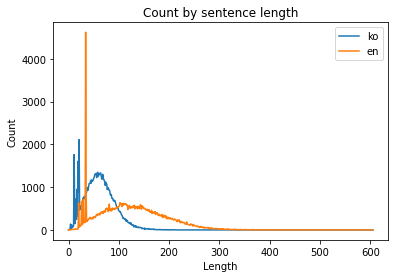

In [6]:
def length_count_vis(copy):
    # 문장별 길이를 구합니다
    copy["ko_len"] = copy["ko"].apply(lambda x : len(x))
    copy["en_len"] = copy["en"].apply(lambda x : len(x))
    
    ko_max_len = max(copy["ko_len"])
    ko_min_len = min(copy["ko_len"])
    en_max_len = max(copy["en_len"])
    en_min_len = min(copy["en_len"])
    
    print(f'한국어 중에서 가장 긴 문장의 길이 : {ko_max_len}')
    print(f'한국어 중에서 가장 짧은 문장의 길이 : {ko_min_len}')
    print("\n")
    print(f'영어 중에서 가장 긴 문장의 길이 : {en_max_len}')
    print(f'영어 중에서 가장 짧은 문장의 길이 : {en_min_len}')
    print("\n")

    # 막대그림의 x축
    max_length = max(ko_max_len, en_max_len)
    min_length = min(ko_min_len, en_min_len)


    # 길이에 따른 데이터 개수를 구합니다.
    ko_len_count = copy["ko_len"].value_counts().sort_index()
    en_len_count = copy["en_len"].value_counts().sort_index()
    # 막대그림의 축의 길이를 맞춰줍니다.

    ko_count = np.zeros(max_length + 1)
    en_count = np.zeros(max_length + 1)
    # 막대그림의 y축
    for i,j in dict(ko_len_count).items():
        ko_count[i] = j
    for i,j in dict(en_len_count).items():
        en_count[i] = j

    print(f"한국어 중에서 가장 많은 데이터 수 : {max(ko_len_count)}")
    print(f"영어 중에서 가장 많은 데이터 수 : {max(en_len_count)}")
    
    plt.plot(ko_count, label = "ko")
    plt.plot(en_count, label = "en")
    plt.legend()
    plt.title("Count by sentence length")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()
    return copy

cp_data = data.copy()
cp_data = length_count_vis(cp_data)

## 3. 데이터 전처리

- 이상치 데이터 제거
- 중복되는 데이터 제거
- 텍스트 전처리
- 결측치 데이터 제거
- 토큰화
- 벡터화

### 3.1 중복 데이터 제거

중복 제거하기 전의 데이터 수 : 94123
중복 제거한 후의 데이터 수 : 74849
한국어 중에서 가장 긴 문장의 길이 : 377
한국어 중에서 가장 짧은 문장의 길이 : 1


영어 중에서 가장 긴 문장의 길이 : 605
영어 중에서 가장 짧은 문장의 길이 : 1


한국어 중에서 가장 많은 데이터 수 : 1218
영어 중에서 가장 많은 데이터 수 : 559


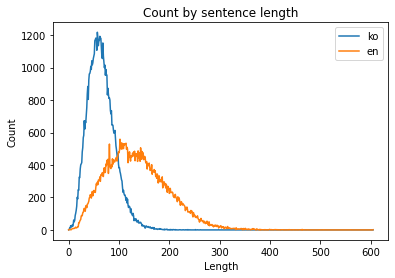

In [7]:
print(f"중복 제거하기 전의 데이터 수 : {len(cp_data)}")
cp_data = cp_data.drop_duplicates("ko")
cp_data = cp_data.drop_duplicates("en")
cp_data = cp_data.reset_index()
print(f"중복 제거한 후의 데이터 수 : {len(cp_data)}")
cp_data = length_count_vis(cp_data)

### 3.1 이상치 데이터 제거

#### 사분위수 범위를 기준으로한 이상치 데이터 제거

upper 
 index     150989.0
ko_len       133.5
en_len       300.0
dtype: float64

lower 
 index     60499.0
ko_len        6.5
en_len       36.0
dtype: float64


이상치 제거하기 전의 데이터 수 : 74849
이상치 제거한 후의 데이터 수 : 71513
한국어 중에서 가장 긴 문장의 길이 : 133
한국어 중에서 가장 짧은 문장의 길이 : 7


영어 중에서 가장 긴 문장의 길이 : 300
영어 중에서 가장 짧은 문장의 길이 : 36


한국어 중에서 가장 많은 데이터 수 : 1215
영어 중에서 가장 많은 데이터 수 : 557


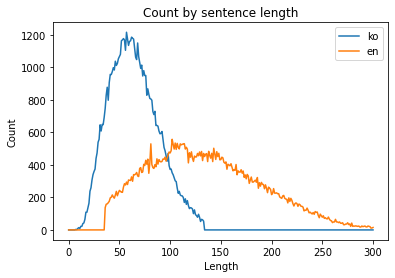

In [8]:
desc = cp_data.copy().describe()
IQR = desc.loc["75%", :] - desc.loc["25%", :]
upper = desc.loc["75%"] + 1.5 * IQR
lower = 1.5 * IQR - desc.loc["25%"]
print(f"upper \n {upper}\n")
print(f"lower \n {lower}")
print("\n")
print(f"이상치 제거하기 전의 데이터 수 : {len(cp_data)}")
cp_data = cp_data[(cp_data["ko_len"] >= lower["ko_len"]) & 
            (cp_data["ko_len"] <= upper["ko_len"])]
cp_data = cp_data[(cp_data["en_len"] >= lower["en_len"]) & 
            (cp_data["en_len"] <= upper["en_len"])]
print(f"이상치 제거한 후의 데이터 수 : {len(cp_data)}")

cp_data = length_count_vis(cp_data)
cp_data = cp_data.reset_index(drop=True)

### 3.3 텍스트 전처리
- 특수기호 제거
- 불용어 제거

In [9]:
def ko_preprocess(x):
    x = re.sub("[^ㄱ-ㅎ가-힣]", " ", x)
    x = re.sub("[ ]+", " ", x)
    return x

def en_preprocess(x):
    x = x.lower()
    x = re.sub(r"[^a-z']", " ", x)
    x = re.sub("[ ]+", " ", x)
    return x


cp_data["ko_pre"] = cp_data["ko"].apply(lambda x: ko_preprocess(x))
cp_data["en_pre"] = cp_data["en"].apply(lambda x: en_preprocess(x))
cp_data.head()

,index,ko,en,ko_len,en_len,ko_pre,en_pre
0,0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",36,55,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐,much of personal computing is about can you to...
1,1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,52,121,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",26,55,그러나 이것은 또한 책상도 필요로 하지 않는다,like all optical mice but it also doesn't need...
3,3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,90,109,달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 팔 그외에 어떤 부분이든 그 움...,uses gyroscopic sensors to control the cursor ...
4,4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,119,224,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,intelligence officials have revealed a spate o...


### 3.4 결측값 데이터 제거

In [10]:
cp_data = cp_data.replace(["",'', " ", ' '], np.nan)
cp_data.isnull().sum()

index      0
ko         0
en         0
ko_len     0
en_len     0
ko_pre    90
en_pre     0
dtype: int64

In [11]:
nan_data = cp_data[cp_data.isnull()["ko_pre"]]
print(f"텍스트 전처리 후 결측 데이터 개수 : {len(nan_data)}")
print(nan_data[["ko","ko_pre"]].head(3))

텍스트 전처리 후 결측 데이터 개수 : 90
                                                     ko ko_pre
6188  BEIJING, China (CNN) ##http://article.joins.co...    NaN
7199  (CNN)/ (JOINS) ##http://article.joins.com/arti...    NaN
7261  (CNN)/ (JOINS) ##http://article.joins.com/arti...    NaN


결측치 제거하기 전의 데이터 수 : 71513
결측치 제거한 후의 데이터 수 : 71423


한국어 중에서 가장 긴 문장의 길이 : 133
한국어 중에서 가장 짧은 문장의 길이 : 7


영어 중에서 가장 긴 문장의 길이 : 300
영어 중에서 가장 짧은 문장의 길이 : 36


한국어 중에서 가장 많은 데이터 수 : 1215
영어 중에서 가장 많은 데이터 수 : 557


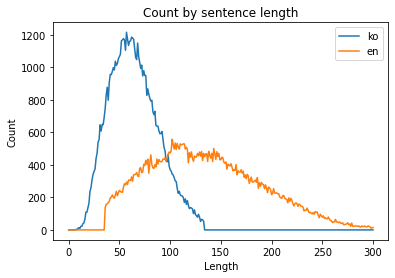

In [12]:
print(f"결측치 제거하기 전의 데이터 수 : {len(cp_data)}")
cp_data = cp_data.dropna()
print(f"결측치 제거한 후의 데이터 수 : {len(cp_data)}")
print("\n")
cp_data = length_count_vis(cp_data)
cp_data = cp_data.reset_index(drop=True)

### 3.5 토큰화

#### 형태소 분절후 빈도 기반 토큰화 - 한국어

In [26]:
mecab = Mecab()
tqdm.pandas()
ko_token = cp_data["ko_pre"].progress_apply(lambda x: mecab.morphs(x))
en_token = cp_data["en_pre"].progress_apply(lambda x: x.split())

100%|██████████| 71423/71423 [00:00<00:00, 229017.50it/s]


In [ ]:
def bin_dict(tokens):
    dic = defaultdict()
    for data in tokens:
        for word in data:
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 0

    dic = sorted(dic.items(), key = lambda x: x[1], reverse = True)
    dic = dict(dic)
    return dic


def word_index(dic):
    word_to_index = defaultdict()
    index_to_word = defaultdict()

    for ind, word in enumerate(dic):
        word_to_index[word] = ind
        index_to_word[ind] = word

    word_to_index = dict(word_to_index)
    index_to_word = dict(index_to_word)
    return word_to_index, index_to_word


def tokenization(token, dictionary):
    tokens = []
    for setence in tqdm(token):
        tmp = [dictionary[word] for word in setence]
        tokens += [tmp]
    return tokens

In [61]:
ko_dic = bin_dict(ko_token)
word_to_index, index_to_word = word_index(ko_dic)
ko_tokenization = tokenization(ko_token, word_to_index)

[('다', 68037), ('이', 66101), ('는', 59792), ('을', 56623), ('의', 48659)]


#### 공백 분절후 빈도 기반 토큰화 - 영어

In [75]:
en_dic = bin_dict(en_token)
en_word_to_index, en_index_to_word = word_index(en_dic)
en_tokenization = tokenization(en_token, en_word_to_index)

100%|██████████| 71423/71423 [00:02<00:00, 33537.41it/s] 


#### 패딩

In [96]:
ko_max_len = len(max(ko_toeknization, key = lambda x: len(x)))
en_max_len = len(max(en_toeknization, key = lambda x: len(x)))
max_len = max(ko_max_len, en_max_len)

ko_tokenization = pad_sequences(ko_tokenization, padding='post', maxlen = max_len)
en_tokenization = pad_sequences(en_tokenization, padding='post', maxlen = max_len)
print(ko_tokenization.shape, en_tokenization.shape)

(71423, 67) (71423, 67)


#### SentencePiece 분절 토큰화 - 한국어

In [104]:
ko_temp_file = "./data/ko_tokenization.tmp"

with open(ko_temp_file, 'w') as f:
    for row in ko_token:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

vocab_size = 5000
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --vocab_size={}'.format(ko_temp_file, vocab_size))  

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

In [115]:
ko_spm_token = list(map(lambda x: s.EncodeAsIds(" ".join(x)), ko_token))
ko_spm_token = pad_sequences(ko_spm_token, padding='post', maxlen = max_len)
ko_spm_token.shape

(71423, 67)

#### SentencePiece 분절 토큰화 - 영어

In [116]:
en_temp_file = "./data/en_tokenization.tmp"

with open(en_temp_file, 'w') as f:
    for row in en_token:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

vocab_size = 5000
spm.SentencePieceTrainer.Train('--input={} --model_prefix=english_spm --vocab_size={}'.format(en_temp_file, vocab_size))  

en_s = spm.SentencePieceProcessor()

In [117]:
en_spm_token = list(map(lambda x: en_s.EncodeAsIds(" ".join(x)), en_token))
en_spm_token = pad_sequences(en_spm_token, padding='post', maxlen = max_len)
en_spm_token.shape

(71423, 67)

In [118]:
ko_spm_token

array([[4998,  847, 4998, ...,    0,    0,    0],
       [4998,   79,  220, ...,    0,    0,    0],
       [4998,   31,  180, ...,    0,    0,    0],
       ...,
       [4998,   31,  180, ...,    0,    0,    0],
       [4998,  600, 4998, ...,    0,    0,    0],
       [4998,  138, 4998, ...,    0,    0,    0]], dtype=int32)

In [120]:
en_spm_token[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

### 3.6 벡터화